## Project: Vanguard A/B Experiment Analysis

In this project, we will analyze the results of an **A/B test** conducted by Vanguard. The goal of the experiment was to evaluate whether a **new, more intuitive user interface (UI)** and the inclusion of **in-context prompts** could improve the client experience and increase the completion rate of an online process.

The experiment included two groups:

- **Control Group**: Clients interacted with Vanguard's traditional interface.
- **Test Group**: Clients used the new interface with interactive elements and contextual help messages.

Our analysis will focus on determining whether the new design resulted in **higher completion rates** and **better user interactions**. 

-------

### Importing Libraries


This script imports the following libraries:

- **`pandas` (`pd`)**: For data manipulation and analysis using DataFrames and Series.
- **`numpy` (`np`)**: For numerical operations and handling arrays.
- **`seaborn` (`sns`)** and **`matplotlib.pyplot` (`plt`)**: For creating statistical data visualizations and customizable plots.
- **`aux_functions` (`f`)**: Custom module with auxiliary functions used throughout the analysis.
- **`proportions_ztest`**: For performing statistical tests comparing proportions.
- **`scipy.stats` (`st`/`stats`)**: For advanced statistical tests and probability distributions.

In [133]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import aux_functions as f
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st
import scipy.stats as stats

### Step 1: Reading the Data

The dataset is loaded from the CSV file `df_clean_all`, which was generated after cleaning and merging all the files provided by Ironhack.  

For details about the cleaning and standardization process, check the **`data`** folder in this repository, where all related steps and files are documented.

In [134]:
df = pd.read_csv("../data/df_clean_all.csv", index_col = None)
df = df.reset_index(drop=True)
df = df.drop(columns='Unnamed: 0')
df['date_time'] = pd.to_datetime(df['date_time'])
df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,testing_engagement,balance_level,tenure,Variation,visitor_id,visit_id,process_step,date_time
0,836976,6.0,73.0,60.5,U,2,45105.30,6.0,9.0,boomers,low,0-100k,5-10,Test,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13
1,836976,6.0,73.0,60.5,U,2,45105.30,6.0,9.0,boomers,low,0-100k,5-10,Test,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:47:50
2,836976,6.0,73.0,60.5,U,2,45105.30,6.0,9.0,boomers,low,0-100k,5-10,Test,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:46:45
3,836976,6.0,73.0,60.5,U,2,45105.30,6.0,9.0,boomers,low,0-100k,5-10,Test,427070339_1413275162,228976764_46825473280_96584,step_3,2017-04-02 11:23:08
4,836976,6.0,73.0,60.5,U,2,45105.30,6.0,9.0,boomers,low,0-100k,5-10,Test,427070339_1413275162,228976764_46825473280_96584,step_2,2017-04-02 11:22:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317118,7468138,18.0,222.0,61.0,F,3,209278.15,0.0,3.0,boomers,low,100-500k,15-20,Test,317123960_46820919455,769876461_30381166055_830233,step_2,2017-03-30 23:59:15
317119,7468138,18.0,222.0,61.0,F,3,209278.15,0.0,3.0,boomers,low,100-500k,15-20,Test,317123960_46820919455,769876461_30381166055_830233,step_1,2017-03-30 23:58:51
317120,7468138,18.0,222.0,61.0,F,3,209278.15,0.0,3.0,boomers,low,100-500k,15-20,Test,317123960_46820919455,769876461_30381166055_830233,start,2017-03-30 23:58:40
317121,7468138,18.0,222.0,61.0,F,3,209278.15,0.0,3.0,boomers,low,100-500k,15-20,Test,317123960_46820919455,769876461_30381166055_830233,start,2017-03-30 23:55:11


In [135]:
df.dtypes

client_id                      int64
clnt_tenure_yr               float64
clnt_tenure_mnth             float64
clnt_age                     float64
gendr                         object
num_accts                      int64
bal                          float64
calls_6_mnth                 float64
logons_6_mnth                float64
generation                    object
testing_engagement            object
balance_level                 object
tenure                        object
Variation                     object
visitor_id                    object
visit_id                      object
process_step                  object
date_time             datetime64[ns]
dtype: object

### Step 2: Understanding the Demographics & Interactions of Each Testing Group

We will visualize the characteristics of our database clients' profiles to gain a deeper understanding of whether the user segmentation for each group aligns with the experiment's design objectives. 

Key questions to address include:

- Who are the primary clients using this online process?
- Are the primary clients younger or older?
- Are the primary clients new or long-standing?

In [136]:
# Creating two datasets to better understand the composition of each group
# Filter the data to create a dataset for the control group
df_control = df[df['Variation']== 'Control']
# Filter the data to create a dataset for the test group
df_test = df[df['Variation']== 'Test']

In [137]:
# Number of clients for each group 
num_clients_control = df_control['client_id'].nunique()
num_clients_test = df_test['client_id'].nunique()
#Print resul
print(f"Sample size control: {num_clients_control} \nSample size test: {num_clients_test}")

Sample size control: 23526 
Sample size test: 26961


In [138]:
#Check if sample data is okay

# Standart parameters
alpha = 0.05  # Significance level (5%)
power = 0.80  # Desired power (80%)
effect_size = 0.02  # Minimum conversion rate difference to detect
p_control = 0.10  # Estimated proportion for the control group

# Calculate the critical Z value for alpha and power
z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z for the significance level (95% confidence)
z_beta = stats.norm.ppf(power)  # Z for the desired power (80%)

# Calculate the sample size using the formula
# n = (Z_alpha^2 * p * (1 - p)) / d^2
# Where p is the estimated proportion and d is the effect size (the expected difference)

n = (z_alpha**2 * p_control * (1 - p_control)) / (effect_size**2)

# Show the calculated sample size
print(f"Required sample size per group: {np.ceil(n)}")

# Actual sample size
n_control = 23526
n_test = 26961

# Check if the actual sample size is sufficient
if n_control >= np.ceil(n) and n_test >= np.ceil(n):
    print("The sample size is sufficient to detect a significant difference.")
else:
    print("The sample size is not sufficient. Consider increasing the sample size.")

Required sample size per group: 865.0
The sample size is sufficient to detect a significant difference.


   client_id                      visit_id  interaction_count    group
0       1028  557292053_87239438319_391157                  9  Control
1       1104  543158812_46395476577_767725                  1  Control
2       1104   643221571_99977972121_69283                  1  Control
3       1186  507052512_11309370126_442139                  1  Control
4       1186  795373564_99931517312_810896                  3  Control
['Control' 'Test']


C:\Users\celia\AppData\Local\Temp\ipykernel_19240\179755698.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


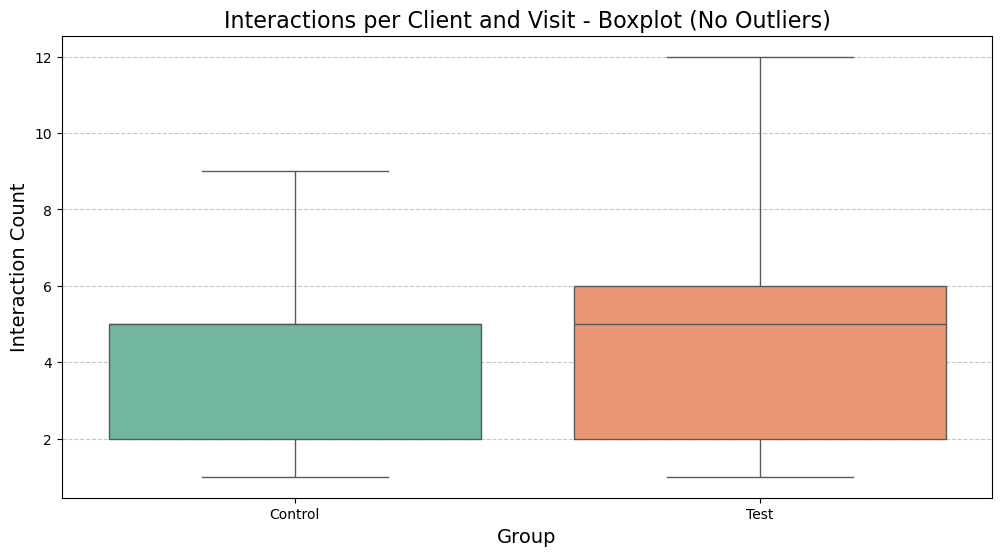

In [139]:
# Group data to calculate interactions per client and visit in the control group
interactions_per_visit_control = (
    df_control.groupby(['client_id', 'visit_id'])  # Group by client_id and visit_id
    .size()  # Count the number of interactions in each group
    .reset_index(name='interaction_count')  # Reset the index and name the count column
)

# Group data to calculate interactions per client and visit in the test group
interactions_per_visit_test = (
    df_test.groupby(['client_id', 'visit_id'])  # Group by client_id and visit_id
    .size()  # Count the number of interactions in each group
    .reset_index(name='interaction_count')  # Reset the index and name the count column
)

# Add a column to distinguish the control group
interactions_per_visit_control['group'] = 'Control'

# Add a column to distinguish the test group
interactions_per_visit_test['group'] = 'Test'

# Combine both DataFrames for visualization
combined_data = pd.concat([interactions_per_visit_control, interactions_per_visit_test], ignore_index=True)

# Verify the combined DataFrame structure
print(combined_data.head())  # Check the first few rows
print(combined_data['group'].unique())  # Ensure the groups are ['Control', 'Test']

# Create a boxplot to compare interaction distributions between groups
plt.figure(figsize=(12, 6))  # Set the figure size
sns.boxplot(
    data=combined_data,  # Use the combined DataFrame
    x='group',  # Group column on the x-axis
    y='interaction_count',  # Interaction counts on the y-axis
    palette='Set2',  # Use a color palette for differentiation
    showfliers=False  # Exclude outliers for a cleaner visualization
)

# Add chart title and axis labels
plt.title('Interactions per Client and Visit - Boxplot (No Outliers)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Interaction Count', fontsize=14)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [140]:
#Creating frequency and propotion tables for the gender column
frequency_table_control, proportion_table_control, frequency_table_test, proportion_table_test = f.create_frequency_table(df_control, df_test, 'gendr')

C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2789152936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table_control.index, y=frequency_table_control.values, palette="Set3");
C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2789152936.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table_test.index, y=frequency_table_test.values, palette="Set3");


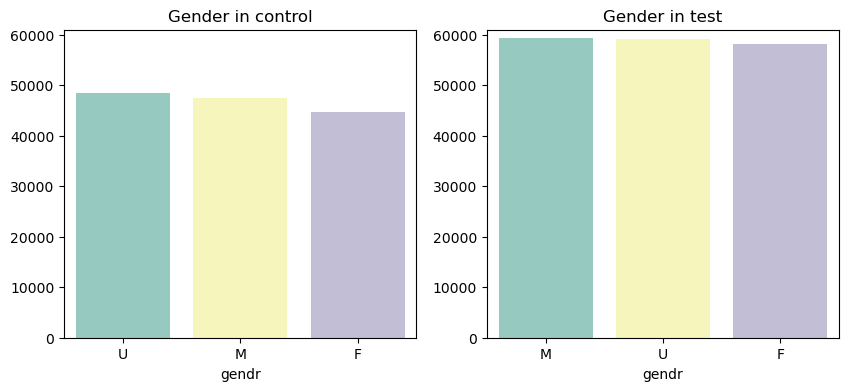

In [141]:
# Visualizing gender distribution for each group (control and test) using a bar plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x=frequency_table_control.index, y=frequency_table_control.values, palette="Set3");
plt.ylim([0,61000])
plt.title('Gender in control')
plt.subplot(1,2,2)
sns.barplot(x=frequency_table_test.index, y=frequency_table_test.values, palette="Set3");
plt.ylim([0,61000])
plt.title('Gender in test')
plt.show()

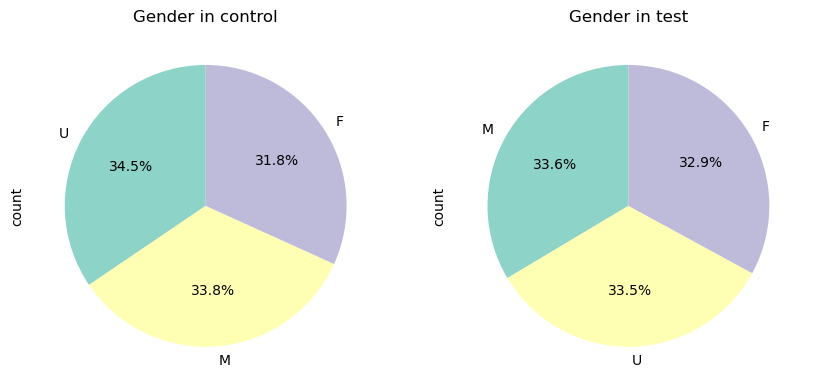

In [142]:
# Visualizing gender distribution for each group (control and test) using a pie chart
plt.figure(figsize=(10,9))
plt.subplot(1,2,1)
frequency_table_control.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Gender in control')
plt.subplot(1,2,2)
frequency_table_test.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Gender in test')
plt.show()

In [143]:
#Creating frequency and propotion tables for the generation column
frequency_table_generation_control, proportion_table_generation_control, frequency_table_generation_test, proportion_table_generation_test = f.create_frequency_table(df_control, df_test, 'generation')

C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2108880550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=frequency_table_generation_control.index, y=frequency_table_generation_control.values, palette="Set3");
C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2108880550.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=frequency_table_generation_test.index, y=frequency_table_generation_test.values, palette="Set3");


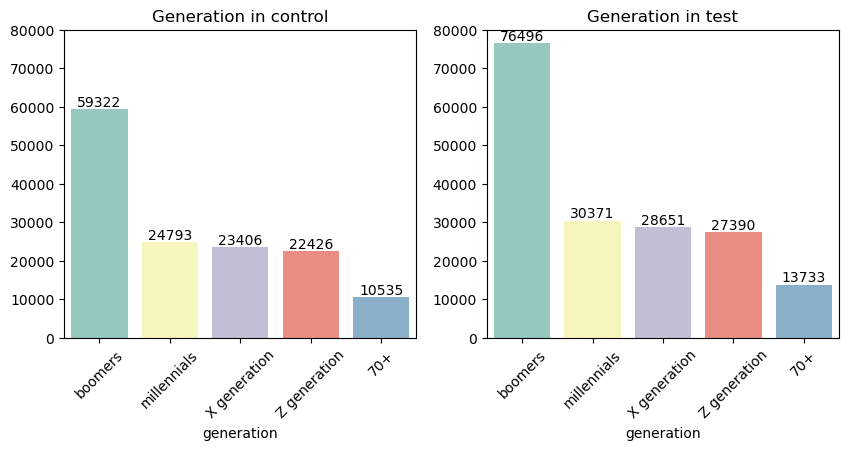

In [144]:
# Visualizing generation distribution for each group (control and test) using a bar plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ax=sns.barplot(x=frequency_table_generation_control.index, y=frequency_table_generation_control.values, palette="Set3");
# Add numbers in each bar
for container in ax.containers:
    ax.bar_label(container) 
plt.ylim([0,80000])
plt.xticks(rotation=45)
plt.title('Generation in control')
plt.subplot(1,2,2)
ax=sns.barplot(x=frequency_table_generation_test.index, y=frequency_table_generation_test.values, palette="Set3");
# Add numbers in each bar
for container in ax.containers:
    ax.bar_label(container) 
plt.ylim([0,80000])
plt.xticks(rotation=45)
plt.title('Generation in test')
plt.show()

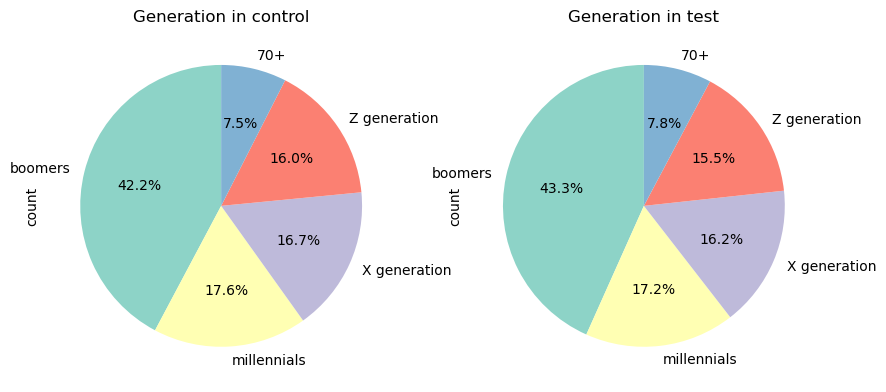

In [145]:
# Visualizing generation distribution for each group (control and test) using a pie chart
plt.figure(figsize=(10,9))
plt.subplot(1,2,1)
frequency_table_generation_control.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Generation in control')
plt.subplot(1,2,2)
frequency_table_generation_test.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Generation in test')
plt.show()

In [146]:
#Creating frequency and propotion tables for the tenure column
frequency_table_tenure_control, proportion_table_tenure_control, frequency_table_tenure_test, proportion_table_tenure_test = f.create_frequency_table(df_control, df_test, 'tenure')

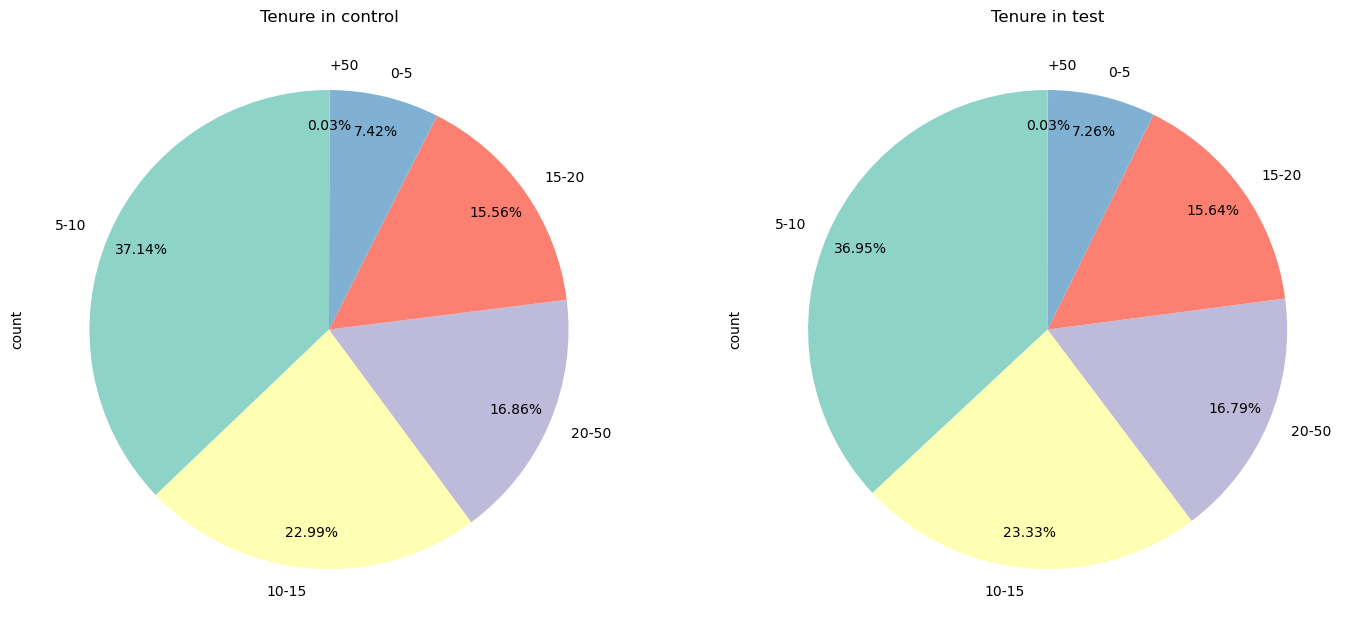

In [147]:
# Visualizing tenure distribution for each group (control and test) using a pie chart
plt.figure(figsize=(17,9))
plt.subplot(1,2,1)
frequency_table_tenure_control.plot.pie(autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85, labeldistance=1.1  )

plt.title('Tenure in control')
plt.subplot(1,2,2)
frequency_table_tenure_test.plot.pie(autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85, labeldistance=1.1 )
plt.title('Tenure in test')
plt.show()

In [148]:
#Creating frequency and propotion tables for the balance
frequency_table_balance_level_control, proportion_table_balance_level_control, frequency_table_balance_level_test, proportion_table_balance_level_test = f.create_frequency_table(df_control, df_test, 'balance_level')

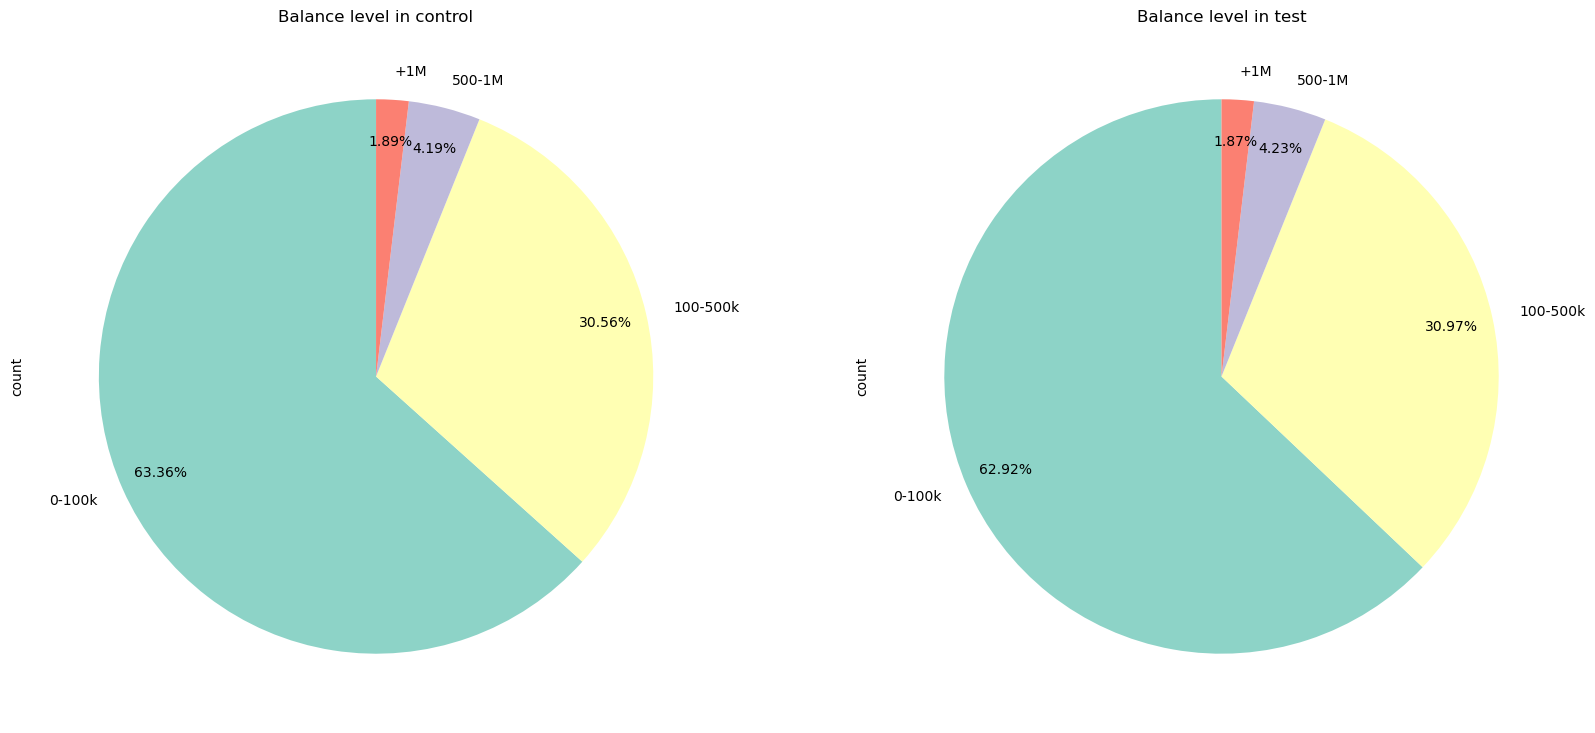

In [149]:
# Visualizing balance distribution for each group (control and test) using a pie chart
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
frequency_table_balance_level_control.plot.pie(autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85, labeldistance=1.1  )

plt.title('Balance level in control')
plt.subplot(1,2,2)
frequency_table_balance_level_test.plot.pie(autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85, labeldistance=1.1 )
plt.title('Balance level in test')
plt.show()

#### Review there aren't any clients in control and test at the same time- Answer: No common clients

In [150]:
#clientes_control = df_control['client_id'].tolist()
#clientes_test = df_test['client_id'].tolist()

#both_experiments = []

#for i in clientes_control:
    #if i in clientes_test: 
        #both_experiments.append(i)

In [151]:
#both_experiments

### Step 3: Key Performance Indicators (KPIs)

1. **Completion Rate:** The percentage of users who reach the final *confirm* step.
2. **Time Spent between Each Step:** The average time users spend transitioning from one step to the next in the process.
3. **Error Rates:** Instances where users move backward to a previous step may indicate confusion or an error. This backward navigation should be considered an error, especially if users transition from a later step to an earlier one.
4. **User Navigation per Visit ID:** Analyzing the user journey to identify where users typically stop their process.

### Completion Rate: The percentage of users who reach the final *confirm* step.

In [152]:
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
df['step_order'] = df['process_step'].map(step_order)

In [153]:
df = df.sort_values(by=['visit_id', 'step_order'])
df[['client_id', 'visit_id', 'process_step', 'date_time']]

,client_id,visit_id,process_step,date_time
300409,3561384,100012776_37918976071_457913,confirm,2017-04-26 13:23:09
300410,3561384,100012776_37918976071_457913,confirm,2017-04-26 13:22:17
76848,7338123,100019538_17884295066_43909,start,2017-04-09 16:21:59
76849,7338123,100019538_17884295066_43909,start,2017-04-09 16:21:45
76854,7338123,100019538_17884295066_43909,start,2017-04-09 16:20:56
...,...,...,...,...
196186,6627522,999988789_76411676596_272843,start,2017-04-21 23:51:09
196190,6627522,999988789_76411676596_272843,start,2017-04-21 23:49:11
196187,6627522,999988789_76411676596_272843,step_1,2017-04-21 23:51:00
196189,6627522,999988789_76411676596_272843,step_1,2017-04-21 23:49:22


In [154]:
df_test = df[df['Variation'] == 'Test']
df_test = df_test.sort_values(by=['visit_id', 'step_order'])
df_control = df[df['Variation'] == 'Control']
df_control = df_control.sort_values(by=['visit_id', 'step_order'])

In [155]:
df_test_no_repetition = f.no_repetition(df_test)
df_control_no_repetition = f.no_repetition(df_control)

In [156]:
completation_rate_test_no_rep = f.step_rate(df_test_no_repetition, 'confirm')
completation_rate_test_no_rep

69.21

In [157]:
# Test completion rate for test group
df_test[df_test["process_step"] == "confirm"]
df_test['repetition'] = df_test.duplicated(subset=["visit_id", "process_step"], keep="last")
df_test
df_test_no_repetition = df_test[df_test['repetition'] == False]
df_test_no_repetition
df_test_confirm = df_test_no_repetition[df_test_no_repetition["process_step"] == "confirm"].groupby("client_id").agg({"process_step":"count"})
round(df_test_confirm.shape[0]/df_test.groupby("client_id").agg({"process_step":"count"}).shape[0]*100, 2)

69.1

In [158]:
completation_rate_control_no_rep = f.step_rate(df_control_no_repetition, 'confirm')
completation_rate_control_no_rep

65.51

In [159]:
# Test completion rate for test group
df_control[df_control["process_step"] == "confirm"]
df_control['repetition'] = df_control.duplicated(subset=["visit_id", "process_step"], keep="last")
df_control
df_control_no_repetition = df_control[df_control['repetition'] == False]
df_control_no_repetition
df_control_confirm = df_control_no_repetition[df_control_no_repetition["process_step"] == "confirm"].groupby("client_id").agg({"process_step":"count"})
round(df_control_confirm.shape[0]/df_control.groupby("client_id").agg({"process_step":"count"}).shape[0]*100, 2)

65.4

### Time Spent between Each Step: The average time users spend transitioning from one step to the next in the process.

In [160]:
df_control_no_repetition[['client_id', 'visit_id', 'process_step', 'date_time']].sort_values(by=['visit_id', 'date_time', 'client_id'])

,client_id,visit_id,process_step,date_time
148115,105007,100030127_47967100085_936361,start,2017-03-22 11:07:49
226763,5623007,100037962_47432393712_705583,start,2017-04-14 16:41:51
226761,5623007,100037962_47432393712_705583,step_1,2017-04-14 16:43:55
136962,4823947,100057941_88477660212_944512,start,2017-04-09 11:30:10
136961,4823947,100057941_88477660212_944512,step_1,2017-04-09 11:30:40
...,...,...,...,...
96143,4064969,999985675_64610694964_443659,start,2017-04-20 09:45:18
96142,4064969,999985675_64610694964_443659,step_1,2017-04-20 09:46:26
96141,4064969,999985675_64610694964_443659,step_2,2017-04-20 09:47:04
96140,4064969,999985675_64610694964_443659,step_3,2017-04-20 09:48:45


In [161]:
df_control_no_repetition.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'generation',
       'testing_engagement', 'balance_level', 'tenure', 'Variation',
       'visitor_id', 'visit_id', 'process_step', 'date_time', 'step_order',
       'repetition'],
      dtype='object')

In [162]:
df_control_no_repetition[['client_id', 'visit_id', 'process_step', 'date_time']]

,client_id,visit_id,process_step,date_time
148115,105007,100030127_47967100085_936361,start,2017-03-22 11:07:49
226763,5623007,100037962_47432393712_705583,start,2017-04-14 16:41:51
226761,5623007,100037962_47432393712_705583,step_1,2017-04-14 16:43:55
136962,4823947,100057941_88477660212_944512,start,2017-04-09 11:30:10
136961,4823947,100057941_88477660212_944512,step_1,2017-04-09 11:30:40
...,...,...,...,...
96143,4064969,999985675_64610694964_443659,start,2017-04-20 09:45:18
96142,4064969,999985675_64610694964_443659,step_1,2017-04-20 09:46:26
96141,4064969,999985675_64610694964_443659,step_2,2017-04-20 09:47:04
96140,4064969,999985675_64610694964_443659,step_3,2017-04-20 09:48:45


In [163]:
df_control_tiempo = f.time_spent_each_step(df_control_no_repetition)
df_control_tiempo[['client_id', 'visit_id', 'process_step', 'date_time', 'time_spent']]
df_control_tiempo = df_control_tiempo.sort_values(by=['visit_id', 'date_time', 'process_step'])
#df_control_tiempo['time_spent'] = df_control_tiempo.groupby(by = 'visit_id')['time_spent'].shift(-1)
df_control_tiempo[['client_id', 'visit_id', 'process_step', 'date_time', 'time_spent']]

c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step_order'] = df['process_step'].map(step_order)


,client_id,visit_id,process_step,date_time,time_spent
148115,105007,100030127_47967100085_936361,start,2017-03-22 11:07:49,NaT
226763,5623007,100037962_47432393712_705583,start,2017-04-14 16:41:51,0 days 00:02:04
226761,5623007,100037962_47432393712_705583,step_1,2017-04-14 16:43:55,NaT
136962,4823947,100057941_88477660212_944512,start,2017-04-09 11:30:10,0 days 00:00:30
136961,4823947,100057941_88477660212_944512,step_1,2017-04-09 11:30:40,0 days 00:01:10
...,...,...,...,...,...
96143,4064969,999985675_64610694964_443659,start,2017-04-20 09:45:18,0 days 00:01:08
96142,4064969,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,0 days 00:00:38
96141,4064969,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,0 days 00:01:41
96140,4064969,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,0 days 00:14:03


In [164]:
df_control_tiempo['time_in_second'] = df_control_tiempo['time_spent'].dt.total_seconds()

In [165]:
visit_id_eliminar = df_control_tiempo[df_control_tiempo['time_in_second'] < 0]['visit_id'].tolist()

In [166]:
df_control_tiempo[df_control_tiempo['time_in_second'] < 0]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,time_spent,time_in_second
183299,769715,8.0,103.0,64.0,U,2,59845.04,5.0,8.0,boomers,...,5-10,Control,501955678_77209379909,241333226_89001272168_496553,confirm,2017-05-23 12:30:49,4,False,-1 days +23:49:39,-621.0
13239,3339110,5.0,66.0,27.0,U,2,38059.73,2.0,5.0,Z generation,...,5-10,Control,701628874_75850441911,573334581_11240139927_381546,confirm,2017-05-13 21:15:42,4,False,-1 days +23:32:06,-1674.0
238470,3498846,6.0,81.0,24.0,U,2,25356.32,2.0,5.0,Z generation,...,5-10,Control,248683636_35645058286,967812877_85712607500_989038,start,2017-06-14 15:50:34,0,False,-1 days +23:30:38,-1762.0


In [167]:
visit_id_eliminar

['241333226_89001272168_496553',
 '573334581_11240139927_381546',
 '967812877_85712607500_989038']

In [168]:
df_control_tiempo = df_control_tiempo[~df_control_tiempo['visit_id'].isin(visit_id_eliminar)]

In [169]:
df_control_tiempo[df_control_tiempo['time_in_second'] < 0]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,time_spent,time_in_second


In [170]:
visit_id_eliminar = df_control_tiempo[(df_control_tiempo['process_step'] == 'confirm')& (df_control_tiempo['time_in_second'] > 0 )]['visit_id'].tolist()

In [171]:
visit_id_eliminar

['425715333_7558165343_290767', '606208309_21627948203_776323']

In [172]:
df_control_tiempo = df_control_tiempo[~df_control_tiempo['visit_id'].isin(visit_id_eliminar)]

In [173]:
avg_time_per_step_control = df_control_tiempo.groupby('process_step')['time_spent'].mean()
avg_time_per_step_control

process_step
confirm                         NaT
start     0 days 00:01:02.792092001
step_1    0 days 00:00:49.041216486
step_2    0 days 00:01:50.975742135
step_3    0 days 00:02:46.346782129
Name: time_spent, dtype: timedelta64[ns]

In [174]:
avg_time_per_step_control_second = df_control_tiempo.groupby('process_step')['time_in_second'].mean()
avg_time_per_step_control_second

process_step
confirm           NaN
start       62.792092
step_1      49.041216
step_2     110.975742
step_3     166.346782
Name: time_in_second, dtype: float64

In [175]:
df_avg_second_control = pd.DataFrame(avg_time_per_step_control_second).reset_index()
df_avg_second_control = df_avg_second_control[df_avg_second_control['process_step']!='confirm']
df_avg_second_control

,process_step,time_in_second
1,start,62.792092
2,step_1,49.041216
3,step_2,110.975742
4,step_3,166.346782


In [176]:
df_test_no_repetition[['client_id', 'visit_id', 'process_step', 'date_time']].sort_values(by=['visit_id', 'date_time', 'client_id'])

,client_id,visit_id,process_step,date_time
300410,3561384,100012776_37918976071_457913,confirm,2017-04-26 13:22:17
76854,7338123,100019538_17884295066_43909,start,2017-04-09 16:20:56
76853,7338123,100019538_17884295066_43909,step_1,2017-04-09 16:21:12
76852,7338123,100019538_17884295066_43909,step_2,2017-04-09 16:21:21
76845,7338123,100019538_17884295066_43909,step_3,2017-04-09 16:24:01
...,...,...,...,...
304104,829911,999984454_18731538378_781808,step_3,2017-03-29 11:20:23
304103,829911,999984454_18731538378_781808,confirm,2017-03-29 11:21:07
196190,6627522,999988789_76411676596_272843,start,2017-04-21 23:49:11
196189,6627522,999988789_76411676596_272843,step_1,2017-04-21 23:49:22


In [177]:
df_test_tiempo = f.time_spent_each_step(df_test_no_repetition)
df_test_tiempo[['client_id', 'visit_id', 'process_step', 'time_spent']]

c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step_order'] = df['process_step'].map(step_order)


,client_id,visit_id,process_step,time_spent
252082,555,637149525_38041617439_716659,start,0 days 00:00:07
252081,555,637149525_38041617439_716659,step_1,0 days 00:00:32
252080,555,637149525_38041617439_716659,step_2,0 days 00:01:39
252079,555,637149525_38041617439_716659,step_3,0 days 00:00:20
252078,555,637149525_38041617439_716659,confirm,NaT
...,...,...,...,...
306138,9999729,870243567_56915814033_814203,confirm,NaT
306133,9999729,99583652_41711450505_426179,start,0 days 00:00:15
306132,9999729,99583652_41711450505_426179,step_1,NaT
50558,9999832,472154369_16714624241_585315,start,0 days 00:00:08


In [178]:
df_test_tiempo['time_in_second'] = df_test_tiempo['time_spent'].dt.total_seconds()

In [179]:

visit_id_eliminar = df_test_tiempo[df_test_tiempo['time_in_second'] < 0]['visit_id'].tolist()
df_test_tiempo = df_test_tiempo[~df_test_tiempo['visit_id'].isin(visit_id_eliminar)]
df_test_tiempo[df_test_tiempo['time_in_second'] < 0]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,time_spent,time_in_second


In [180]:
visit_id_eliminar = df_test_tiempo[(df_test_tiempo['process_step'] == 'confirm')& (df_test_tiempo['time_in_second'] > 0 )]['visit_id'].tolist()
df_test_tiempo = df_test_tiempo[~df_test_tiempo['visit_id'].isin(visit_id_eliminar)]
df_test_tiempo[(df_test_tiempo['process_step'] == 'confirm')& (df_test_tiempo['time_in_second'] > 0 )]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,time_spent,time_in_second


In [181]:
avg_time_per_step_test = f.mean_time_spent(df_test_tiempo)
avg_time_per_step_test

process_step
confirm                         NaT
start     0 days 00:00:52.280573214
step_1    0 days 00:01:14.009141068
step_2    0 days 00:01:48.310231324
step_3    0 days 00:02:25.599825346
Name: time_spent, dtype: timedelta64[ns]

In [182]:
avg_time_per_step_test_second = df_test_tiempo.groupby('process_step')['time_in_second'].mean()
avg_time_per_step_test_second

process_step
confirm           NaN
start       52.280573
step_1      74.009141
step_2     108.310231
step_3     145.599825
Name: time_in_second, dtype: float64

In [183]:
df_avg_second_test = pd.DataFrame(avg_time_per_step_test_second).reset_index()
df_avg_second_test = df_avg_second_test[df_avg_second_test['process_step']!='confirm']
df_avg_second_test

,process_step,time_in_second
1,start,52.280573
2,step_1,74.009141
3,step_2,108.310231
4,step_3,145.599825


C:\Users\celia\AppData\Local\Temp\ipykernel_19240\4142769933.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='process_step', y='time_in_second', data=df_avg_second_control, palette='viridis')
C:\Users\celia\AppData\Local\Temp\ipykernel_19240\4142769933.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='process_step', y='time_in_second', data=df_avg_second_test, palette='viridis')


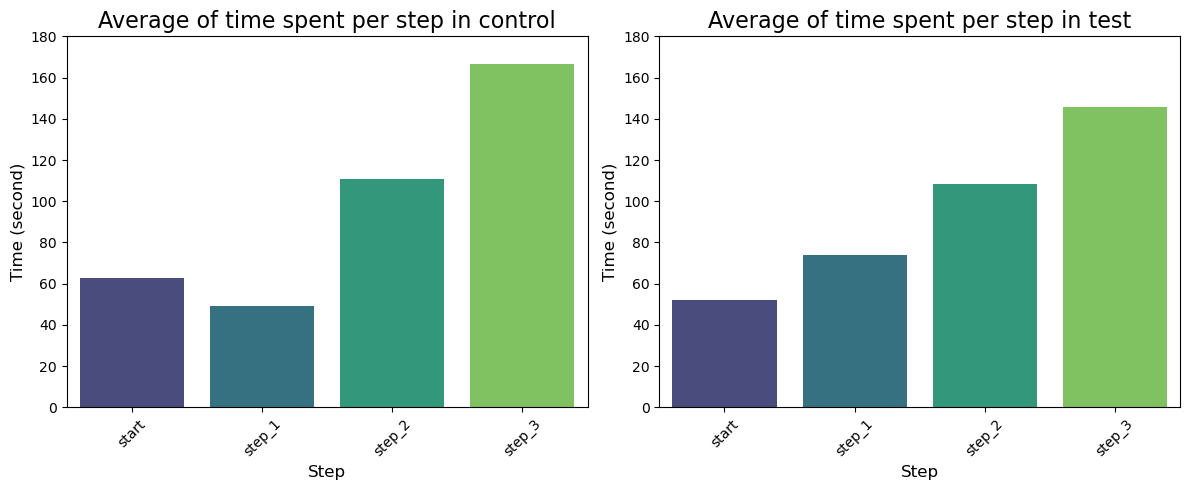

In [184]:



plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.barplot(x='process_step', y='time_in_second', data=df_avg_second_control, palette='viridis')

plt.title('Average of time spent per step in control', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (second)', fontsize=12)
plt.ylim([0,180])
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x='process_step', y='time_in_second', data=df_avg_second_test, palette='viridis')
plt.ylim([0,180])
plt.title('Average of time spent per step in test', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (second)', fontsize=12)
plt.xticks(rotation=45)


plt.tight_layout()

plt.show()

In [185]:
df_avg_second_control['time_in_second'].mean(), df_avg_second_test['time_in_second'].mean()

(97.28895818830637, 95.0499427386151)

### 3. **Error Rates:** If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

In [186]:
df_control = df_control.sort_values(by=['client_id', 'visit_id', 'date_time'])
df_control[['client_id', 'visit_id', 'process_step', 'date_time']]
df_test = df_test.sort_values(by=['client_id', 'visit_id', 'date_time'])

In [187]:
df_control_error = f.transform_to_errores(df_control)
percentage_error_control = f.percentage_errors(df_control_error)
percentage_error_control

Percentage of errors : 6.7830754117965295


6.7830754117965295

In [188]:
df_test_error = f.transform_to_errores(df_test)
percentage_error_test = f.percentage_errors(df_test_error)
percentage_error_test

Percentage of errors : 9.192090171590966


9.192090171590966

##### 3.1 Error rate per category
1. Gender 
2. Generation
3. Testing_engagement 
4. Balance level
5. Tenure


Error rate per generation: generation
70+             0.081633
X generation    0.064214
Z generation    0.065727
boomers         0.071474
millennials     0.058565
Name: is_error, dtype: float64
Error rate per generation: generation
70+             0.125027
X generation    0.081533
Z generation    0.072435
boomers         0.105574
millennials     0.069935
Name: is_error, dtype: float64


c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_control', data=df_control, palette='Set2')
c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_test', data=df_test, palette='Set2')


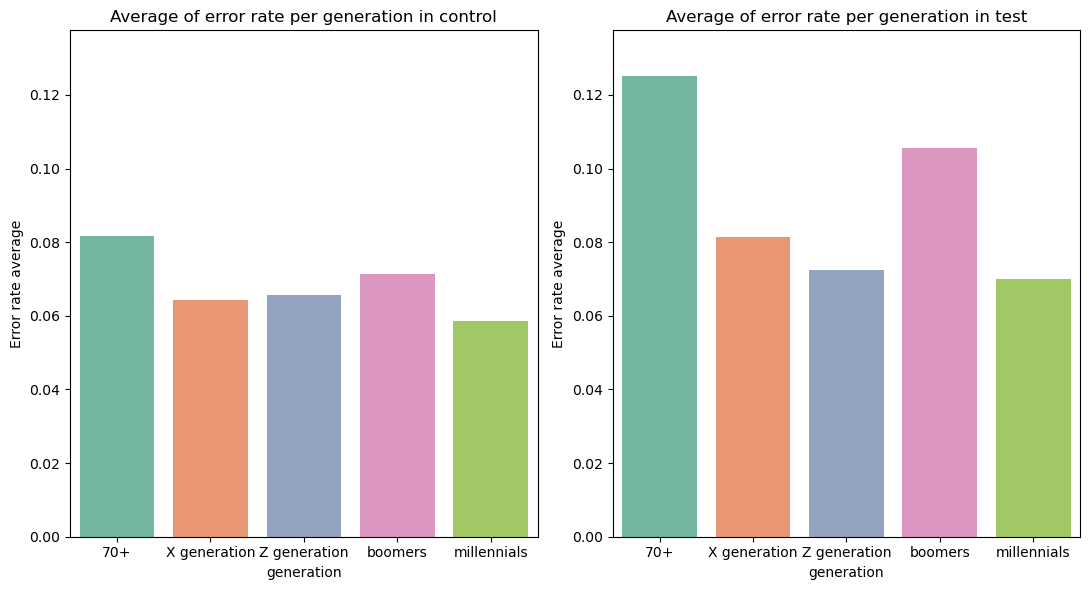

Error rate per testing_engagement: testing_engagement
high    0.060945
low     0.067870
Name: is_error, dtype: float64
Error rate per testing_engagement: testing_engagement
high    0.066127
low     0.092030
Name: is_error, dtype: float64


c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_control', data=df_control, palette='Set2')
c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_test', data=df_test, palette='Set2')


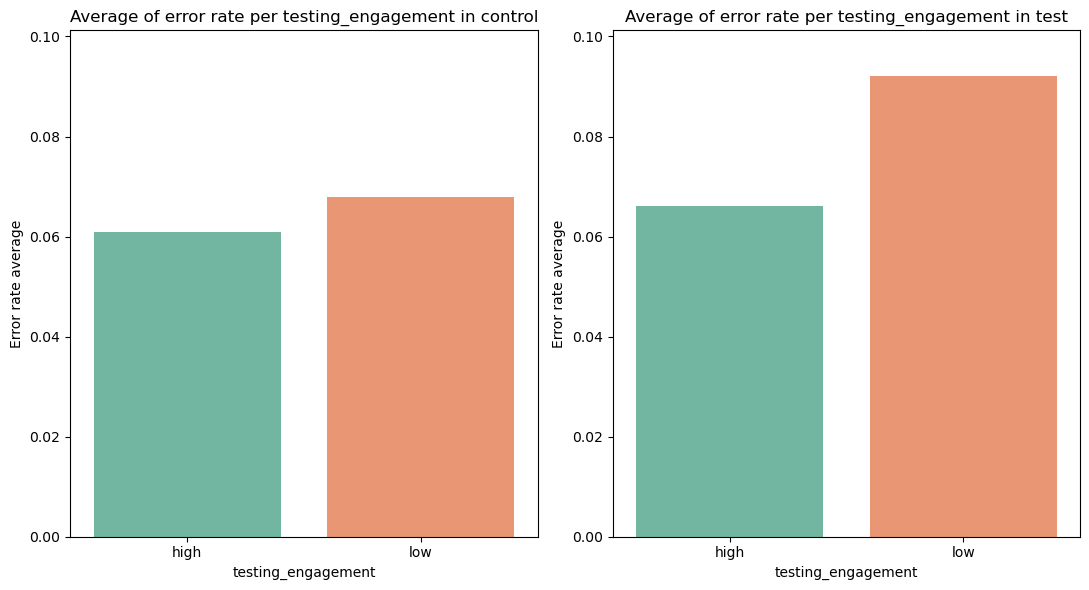

Error rate per balance_level: balance_level
+1M         0.064431
0-100k      0.066761
100-500k    0.069690
500-1M      0.071974
Name: is_error, dtype: float64
Error rate per balance_level: balance_level
+1M         0.092145
0-100k      0.089232
100-500k    0.096887
500-1M      0.095448
Name: is_error, dtype: float64


c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_control', data=df_control, palette='Set2')
c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_test', data=df_test, palette='Set2')


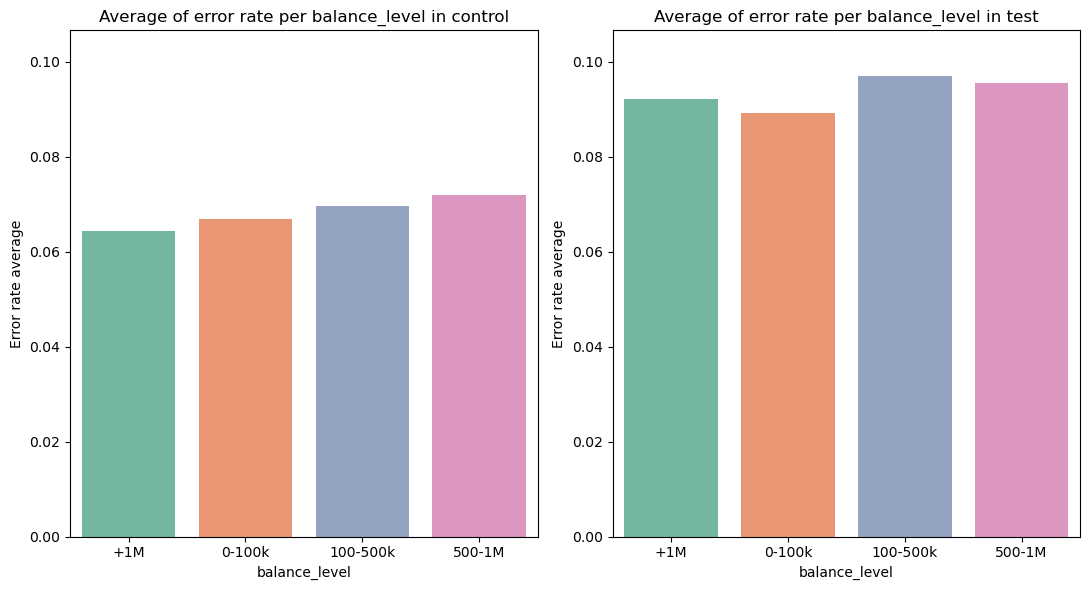

Error rate per tenure: tenure
+50      0.127660
0-5      0.069475
10-15    0.064313
15-20    0.065682
20-50    0.069878
5-10     0.069597
Name: is_error, dtype: float64
Error rate per tenure: tenure
+50      0.061224
0-5      0.086797
10-15    0.092769
15-20    0.096551
20-50    0.098105
5-10     0.087644
Name: is_error, dtype: float64


c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_control', data=df_control, palette='Set2')
c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category, y='error_rate_test', data=df_test, palette='Set2')


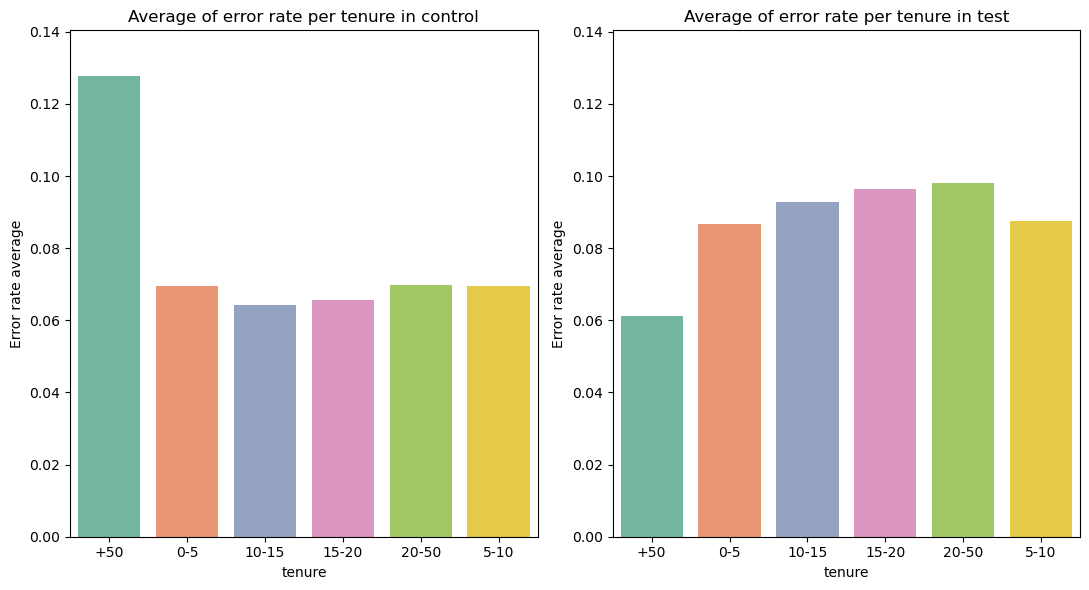

In [189]:
list_category = ['generation','testing_engagement', 'balance_level', 'tenure']
for i in list_category:
    avg_control = f.mean_errors_per_category(df_control_error, i)
    avg_test = f.mean_errors_per_category(df_test_error, i)
    
    f.create_barplot_error(avg_control, avg_test, i)

#### 2.1 Average of time spent per step without errors

In [190]:
df_control_no_repetition['process_step'].unique()

array(['start', 'step_1', 'step_2', 'step_3', 'confirm'], dtype=object)

In [191]:
df_control_error_no_rep = f.transform_to_errores(df_control_no_repetition)
df_test_error_no_rep = f.transform_to_errores(df_test_no_repetition)

In [192]:
df_control_error_no_rep['process_step'].unique()

array(['start', 'step_1', 'step_2', 'step_3', 'confirm'], dtype=object)

In [193]:
df_valid_control = f.without_error(df_control_error_no_rep)
df_valid_control

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,previous_step_order,is_error
298528,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,10-15,Control,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,0,False,NaN,False
298527,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,10-15,Control,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,1,False,0.0,False
298525,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,10-15,Control,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,2,False,1.0,False
298524,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,10-15,Control,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,3,False,2.0,False
130633,1104,5.0,66.0,48.0,U,3,154643.94,6.0,9.0,X generation,...,5-10,Control,194240915_18158000533,543158812_46395476577_767725,start,2017-06-12 07:49:18,0,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141088,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,+50,Control,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:26:02,1,False,0.0,False
141087,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,+50,Control,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:26:47,2,False,1.0,False
141084,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,+50,Control,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:28:00,3,False,2.0,False
141080,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,+50,Control,292425655_16607136645,189177304_69869411700_783154,confirm,2017-03-29 15:37:28,4,False,3.0,False


In [194]:
df_valid_control['process_step'].unique()

array(['start', 'step_1', 'step_2', 'step_3', 'confirm'], dtype=object)

In [195]:
df_valid_test = f.without_error(df_test_error_no_rep)
df_valid_test

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,tenure,Variation,visitor_id,visit_id,process_step,date_time,step_order,repetition,previous_step_order,is_error
252082,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,0-5,Test,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,0,False,NaN,False
252081,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,0-5,Test,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1,False,0.0,False
252080,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,0-5,Test,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,2,False,1.0,False
252079,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,0-5,Test,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,3,False,2.0,False
252078,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,0-5,Test,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,4,False,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306138,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,10-15,Test,834634258_21862004160,870243567_56915814033_814203,confirm,2017-05-08 16:09:40,4,False,3.0,False
306133,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,10-15,Test,604429154_69247391147,99583652_41711450505_426179,start,2017-04-05 13:40:49,0,False,NaN,False
306132,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,10-15,Test,604429154_69247391147,99583652_41711450505_426179,step_1,2017-04-05 13:41:04,1,False,0.0,False
50558,9999832,23.0,281.0,49.0,F,2,431887.61,1.0,4.0,X generation,...,20-50,Test,145538019_54444341400,472154369_16714624241_585315,start,2017-05-16 16:46:03,0,False,NaN,False


In [196]:
df_valid_control_time = f.time_spent_each_step(df_valid_control)
time_spent_control = f.mean_time_spent(df_valid_control_time)
df_time_spent_control = pd.DataFrame(time_spent_control).reset_index()
df_time_spent_control = df_time_spent_control[df_time_spent_control['process_step']!='confirm']
#df_time_spent_control['process_step'] = df_time_spent_control['process_step'].replace({'step_1': 'start', 'step_2': 'step_1', 'step_3':'step_2', 'confirm':'step_3'})
df_time_spent_control = df_time_spent_control.sort_values(by='process_step')
df_time_spent_control

c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step_order'] = df['process_step'].map(step_order)


,process_step,time_spent
1,start,0 days 00:01:02.615763973
2,step_1,0 days 00:00:48.741872070
3,step_2,0 days 00:01:50.156768534
4,step_3,0 days 00:02:46.340894061


In [197]:
df_valid_test_time = f.time_spent_each_step(df_valid_test)
time_spent_test = f.mean_time_spent(df_valid_test_time)
df_time_spent_test = pd.DataFrame(time_spent_test).reset_index()
df_time_spent_test = df_time_spent_test[df_time_spent_test['process_step']!='confirm']
#df_time_spent_test['process_step'] = df_time_spent_test['process_step'].replace({'step_1': 'start', 'step_2': 'step_1', 'step_3':'step_2', 'confirm':'step_3'})
df_time_spent_test = df_time_spent_test.sort_values(by='process_step')
df_time_spent_test

c:\Users\celia\Documents\IronhackDataAnalysis\vanguard-project\analysis\aux_functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step_order'] = df['process_step'].map(step_order)


,process_step,time_spent
1,start,0 days 00:00:52.011767678
2,step_1,0 days 00:01:13.064591213
3,step_2,0 days 00:01:47.483164749
4,step_3,0 days 00:02:24.541320723


C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2129171798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='process_step', y='time_spent_seconds', data=df_time_spent_control, palette='viridis')
C:\Users\celia\AppData\Local\Temp\ipykernel_19240\2129171798.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='process_step', y='time_spent_seconds', data=df_time_spent_test, palette='viridis')


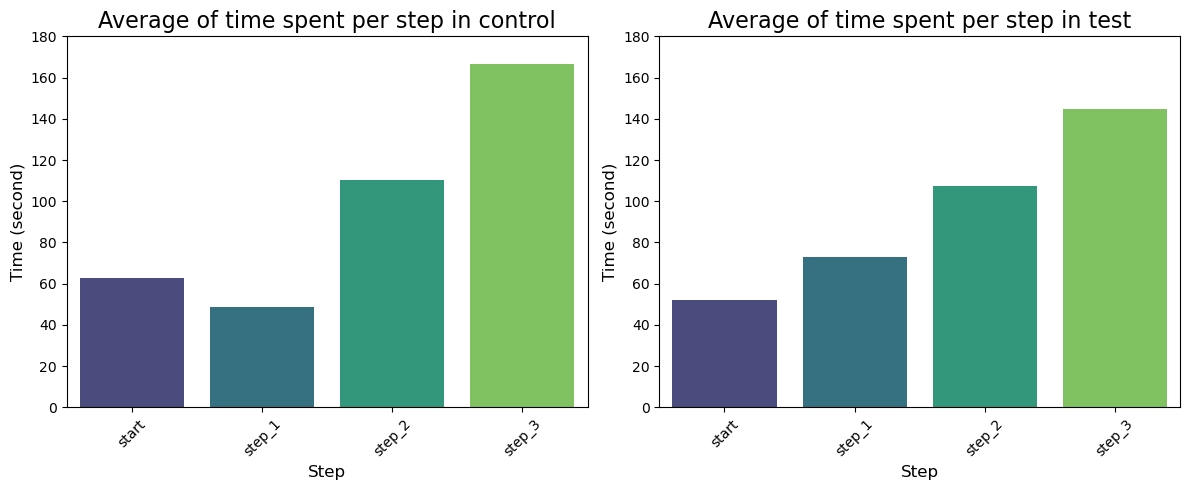

In [198]:
df_time_spent_control['time_spent_seconds'] = df_time_spent_control['time_spent'].dt.total_seconds()
df_time_spent_test['time_spent_seconds'] = df_time_spent_test['time_spent'].dt.total_seconds()


plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.barplot(x='process_step', y='time_spent_seconds', data=df_time_spent_control, palette='viridis')

plt.title('Average of time spent per step in control', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (second)', fontsize=12)
plt.ylim([0,180])
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x='process_step', y='time_spent_seconds', data=df_time_spent_test, palette='viridis')
plt.ylim([0,180])
plt.title('Average of time spent per step in test', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Time (second)', fontsize=12)
plt.xticks(rotation=45)


plt.tight_layout()

plt.show()

In [199]:
df_time_spent_control['time_spent_seconds'].mean(), df_time_spent_test['time_spent_seconds'].mean()

(96.9638246595, 94.27521109075)

In [200]:
df_time_spent_control['time_spent_seconds'].median(), df_time_spent_test['time_spent_seconds'].median()

(86.3862662535, 90.273877981)

In [201]:
df_avg_second_control['time_in_second'].mean(), df_avg_second_test['time_in_second'].mean()

(97.28895818830637, 95.0499427386151)

In [202]:
df_avg_second_control['time_in_second'].median(), df_avg_second_test['time_in_second'].median()

(86.88391706856439, 91.15968619689458)

### Step 4: Hypothesis Testing: 

1. **Completion Rate Difference**: 
   - Tested whether the difference in completion rate between the new design and the old design is statistically significant.
   
2. **Completion Rate Improvement**:
   - Analyzed if the observed increase in completion rate from the A/B test meets or exceeds a 5% improvement threshold.

3. **Additional Hypothesis Test**:
   - Performed another hypothesis test of your choice to further assess the validity or performance of the designs.

4. **Evaluation of the Experiment**:
   - Assessed the overall experiment by addressing the following key questions:
     - **Design Effectiveness**: Did the new design achieve its intended goals?
     - **Duration**: Was the experiment duration adequate to capture meaningful results?
     - **Additional Data Needs**: Is more data required to strengthen the conclusions of the experiment?

In [203]:
df = df.sort_values(by=['client_id', 'visit_id', 'date_time'])
df = f.no_repetition(df)

### 1. Confirmed if the difference in completetion rate of the new design and the old design is statistically significant. 

In [204]:
# Create a new column 'reached_confirm' that is True if user pass by 'confirm' step and False on the opposite case
df['reached_confirm'] = df['process_step'] == 'confirm'

# Filter DataFrame for groups "test" and "control"
df_test = df[df['Variation'] == 'Test']
df_control = df[df['Variation'] == 'Control']

# Create cross tab for  "test" group
contingency_test = pd.crosstab(df_test['visit_id'], df_test['reached_confirm'], 
                                rownames=['visit_id'], colnames=['reached_confirm'], 
                                margins=True, margins_name="Total")

# Create cross tab for "control" group
contingency_control = pd.crosstab(df_control['visit_id'], df_control['reached_confirm'], 
                                   rownames=['visit_id'], colnames=['reached_confirm'], 
                                   margins=True, margins_name="Total")

In [205]:
contingency_control

reached_confirm,False,True,Total
visit_id,,,
100030127_47967100085_936361,1,0,1
100037962_47432393712_705583,3,0,3
100057941_88477660212_944512,7,0,7
10006594_66157970412_679648,4,1,5
100071743_53464757454_616703,1,0,1
...,...,...,...
999890184_77121766521_746360,4,0,4
999936732_27995195904_324897,2,0,2
999951892_54774917180_163890,1,0,1


In [206]:
# Calculate the percentage of users who reached the confirmation step for each group
percent_test = contingency_test[True].sum() / contingency_test['Total'].sum() * 100
percent_control = contingency_control[True].sum() / contingency_control['Total'].sum() * 100

print(f"Percentage of 'Test' users who reached the confirmation step: {percent_test:.2f}%")
print(f"Percentage of 'Confirm' users who reached the confirmation step: {percent_control:.2f}%")

Percentage of 'Test' users who reached the confirmation step: 13.84%
Percentage of 'Confirm' users who reached the confirmation step: 12.69%


### Hypothesis: 
$$
H_0: \text{The completion rate is independent of the design. }
$$

$$
H_1: \text{The completion rate depends on the design. }
$$

The stadistic test is:

$$
Z = \frac{\overline{X} - \mu_0}{\sigma / \sqrt{n}}
$$

Where: 
- $\overline{X}$ is sample mean.
- $\mu_0$ hypothesized population mean.
- $\sigma$ std of the population.
- $n$ sample size.

In other words, if the completion rate is independent of the design means that the design does not affect the task completion rate. 


In [207]:
#Crear la tabla de contingencia para las variables 'Variation' y 'reached_confirm'
contingency_table_variation_confirm = pd.crosstab(df['Variation'], df['reached_confirm'], margins=True, margins_name="Total")
#Usar la funcion para comparar nuestra comparación de hipótesis.
result = f.chi_square_hypothesis(contingency_table_variation_confirm)
# Imprimir los resultados
print(result)
print("The use of either the variation test or the control affects the task completion rate")

{'chi2_statistic': 79.45728737655244, '\np_value': 2.269703986727495e-16, '\ndegrees_of_freedom': 4, '\nconclusion': 'Rechazamos la hipótesis nula. Las variables están asociadas.'}
The use of either the variation test or the control affects the task completion rate


### 2. Carried out an analysis ensuring that the observed increase in completation rate from the A/B test meets or exceeds this 5% threshold.

In [208]:
df_test = df[df['Variation'] == 'Test']
df_control = df[df['Variation'] == 'Control']
success_test = df_test[df_test['process_step'] == 'confirm'].shape[0]
success_control = df_control[df_control['process_step'] == 'confirm'].shape[0]

### Hypothesis: 
$$
H_0: \text{There is no significant difference in completion rates between the two groups. }
$$

$$
H_1: \text{There is a significant difference in completion rates. }
$$

The test stadistic is:

$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1 - \hat{p}) \left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$

Where: 
- $\hat{p}_1, \hat{p}_2$: observed proportions of the two samples.
- $n_1, n_2$: sample sizes.
- $\hat{p}$: combined ratio under the null hypothesis, calculated as:

$$
\hat{p} = \frac{x_1 + x_2}{n_1 + n_2}
$$



In [209]:
total_test = df_test.shape[0]
total_control = df_control.shape[0]

counts = [success_test, success_control]
totals = [total_test, total_control]

stat, p_value = proportions_ztest(counts, totals)

success_rate_test = success_test / total_test
success_rate_control = success_control / total_control

(stat, p_value, success_rate_test, success_rate_control)

(8.913881723275924,
 4.927638778359979e-19,
 0.13836023142509135,
 0.12693090553355318)

### Hypothesis: 
$$
H_0: \text{There is no significant difference in completion rates between the two groups that meets or exceeds over 5\%}
$$

$$
H_1: \text{There is a 5\% significant difference in completion rates. }
$$

In [210]:
cumple, aumento, umbral = f.verificar_mejora_umbral(success_rate_test, success_rate_control)
if cumple:
    print(f"El aumento en la tasa de finalización ({aumento:.4f}) supera el umbral del 5% ({umbral:.4f}). El nuevo diseño se justifica.")
else:
    print(f"El aumento en la tasa de finalización ({aumento:.4f}) no supera el umbral del 5% ({umbral:.4f}). El nuevo diseño no se justifica económicamente.")

El aumento en la tasa de finalización (0.0114) supera el umbral del 5% (0.0063). El nuevo diseño se justifica.


### 3. Other hypothesis

### Hypothesis: 
$$
H_0: \mu_1 = \mu_2,
$$

$$
H_1: \mu_1 \neq \mu_2
$$

where $$\mu_1, \mu_2$$ are respectively the average age of customers interacting with each process (control and test)

The test stadistic is:

$$
t = \frac{\overline{X} - \mu_0}{\frac{s}{\sqrt{n}}}
$$

Where: 
- $\overline{X}$ is sample mean.
- $\mu_0$ is hypothesized population mean.
- $s$ is std of the population.
- $n$ is the sample size.

In [211]:
t_stat, p_value, resultado = f.t_student(df_test, df_control, 'clnt_age')

print(f"Estadístico t: {t_stat}")
print(f"p-valor: {p_value}")
print(resultado)

Estadístico t: 6.966758281112878
p-valor: 3.2505966811818467e-12
Rechazamos la hipótesis nula: son significativamente diferentes.


### Hypothesis: 
$$
H_0: \text{Groups are balanced},
$$

$$
H_1: \text{Groups are not balanced}
$$



In [212]:
f.verificar_tamano_grupos(df)

Número de usuarios en el grupo Test: 157632
Número de usuarios en el grupo Control: 126754
Los grupos no están perfectamente balanceados. La diferencia es de 30878 usuarios.


(157632, 126754, 30878)

### Hypothesis: 
$$
H_0: \text{There is no significant difference in num\_accts between the two groups}
$$

$$
H_1: \text{There is a significant difference in num\_accts. }
$$

In [213]:
f.verificar_aleatorizacion(df, 'num_accts')

Estadístico t: -10.009715836107748
p-valor: 1.3948149842934956e-23
Hay diferencias significativas en la característica 'num_accts' entre los grupos.


(-10.009715836107748, 1.3948149842934956e-23)

### Hypothesis: 
$$
H_0: \text{There is no significant difference in clnt\_age between the two groups}
$$

$$
H_1: \text{There is a significant difference in clnt\_age. }
$$

In [214]:
f.verificar_aleatorizacion(df, 'clnt_age')

Estadístico t: 6.966758281112878
p-valor: 3.2505966811818467e-12
Hay diferencias significativas en la característica 'clnt_age' entre los grupos.


(6.966758281112878, 3.2505966811818467e-12)

### Hypothesis: 
$$
H_0: \text{There is no significant difference in bal between the two groups}
$$

$$
H_1: \text{There is a significant difference in bal. }
$$

In [215]:
f.verificar_aleatorizacion(df, 'bal')

Estadístico t: 1.1378404377109885
p-valor: 0.2551880779489641
No hay diferencias significativas en la característica 'bal' entre los grupos.


(1.1378404377109885, 0.2551880779489641)

### Duration per step testing

In [216]:
df_time_spent_control
df_time_spent_control

,process_step,time_spent,time_spent_seconds
1,start,0 days 00:01:02.615763973,62.615764
2,step_1,0 days 00:00:48.741872070,48.741872
3,step_2,0 days 00:01:50.156768534,110.156769
4,step_3,0 days 00:02:46.340894061,166.340894


In [217]:

df_valid_control_time['time_in_second'] = df_valid_control_time['time_spent'].dt.total_seconds()
#df_valid_control_time.dropna(subset=['time_in_second'], inplace= True)
df_valid_control_time['time_in_second'] = df_valid_control_time['time_spent'].apply(lambda x: x.total_seconds() if x.total_seconds() > 0 else 0)
df_valid_control_time

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,visitor_id,visit_id,process_step,date_time,step_order,repetition,previous_step_order,is_error,time_spent,time_in_second
298528,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,0,False,NaN,False,0 days 00:00:49,49.0
298527,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,1,False,0.0,False,0 days 00:01:12,72.0
298525,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,2,False,1.0,False,0 days 00:04:35,275.0
298524,1028,12.0,145.0,36.0,M,3,103520.22,1.0,4.0,millennials,...,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,3,False,2.0,False,NaT,0.0
130633,1104,5.0,66.0,48.0,U,3,154643.94,6.0,9.0,X generation,...,194240915_18158000533,543158812_46395476577_767725,start,2017-06-12 07:49:18,0,False,NaN,False,NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141088,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:26:02,1,False,0.0,False,0 days 00:00:45,45.0
141087,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:26:47,2,False,1.0,False,0 days 00:01:13,73.0
141084,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:28:00,3,False,2.0,False,0 days 00:09:28,568.0
141080,9998346,50.0,602.0,61.5,F,2,149881.38,6.0,9.0,boomers,...,292425655_16607136645,189177304_69869411700_783154,confirm,2017-03-29 15:37:28,4,False,3.0,False,NaT,0.0


In [218]:
df_valid_test_time['time_in_second'] = df_valid_test_time['time_spent'].dt.total_seconds()
#df_valid_test_time.dropna(subset=['time_in_second'], inplace= True)
df_valid_test_time['time_in_second'] = df_valid_test_time['time_spent'].apply(lambda x: x.total_seconds() if x.total_seconds() > 0 else 0)
df_valid_test_time

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,visitor_id,visit_id,process_step,date_time,step_order,repetition,previous_step_order,is_error,time_spent,time_in_second
252082,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,0,False,NaN,False,0 days 00:00:07,7.0
252081,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1,False,0.0,False,0 days 00:00:32,32.0
252080,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,2,False,1.0,False,0 days 00:01:39,99.0
252079,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,3,False,2.0,False,0 days 00:00:20,20.0
252078,555,3.0,46.0,29.5,U,2,25454.66,2.0,6.0,Z generation,...,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,4,False,3.0,False,NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306138,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,834634258_21862004160,870243567_56915814033_814203,confirm,2017-05-08 16:09:40,4,False,3.0,False,NaT,0.0
306133,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,604429154_69247391147,99583652_41711450505_426179,start,2017-04-05 13:40:49,0,False,NaN,False,0 days 00:00:15,15.0
306132,9999729,10.0,124.0,31.0,F,3,107059.74,6.0,9.0,millennials,...,604429154_69247391147,99583652_41711450505_426179,step_1,2017-04-05 13:41:04,1,False,0.0,False,NaT,0.0
50558,9999832,23.0,281.0,49.0,F,2,431887.61,1.0,4.0,X generation,...,145538019_54444341400,472154369_16714624241_585315,start,2017-05-16 16:46:03,0,False,NaN,False,0 days 00:00:08,8.0


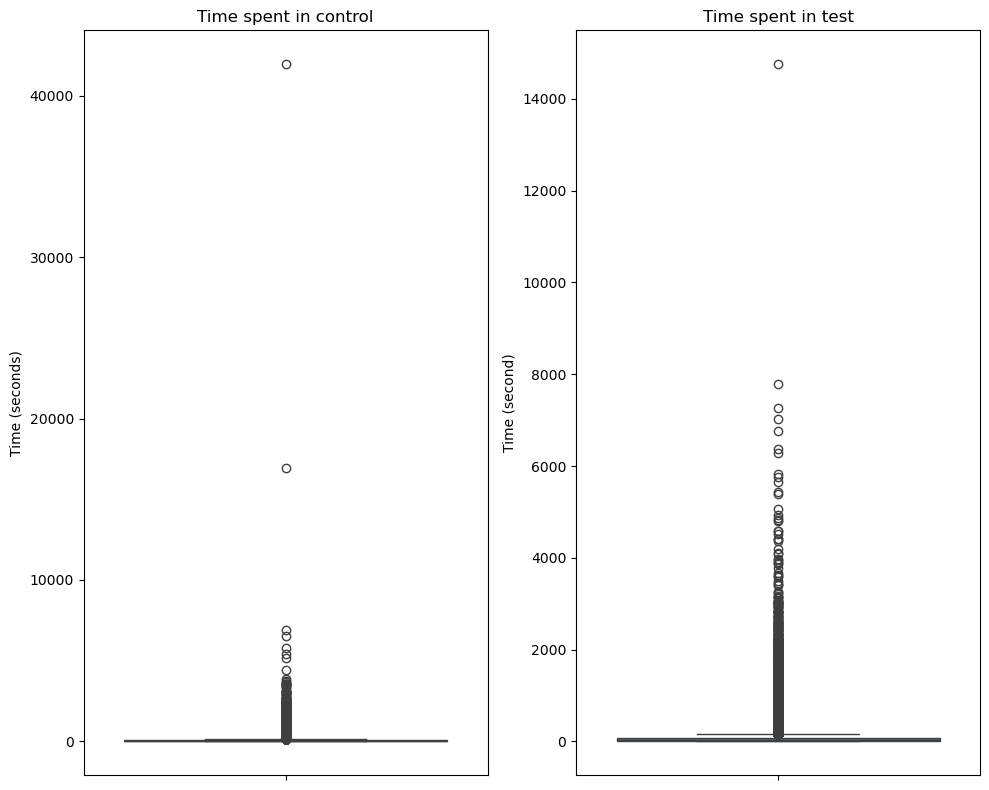

In [219]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.boxplot(y='time_in_second', data=df_valid_control_time)
plt.title('Time spent in control')
plt.ylabel('Time (seconds)')
plt.subplot(1,2,2)
sns.boxplot(y='time_in_second', data=df_valid_test_time)
plt.title('Time spent in test')
plt.ylabel('Time (second)')

plt.tight_layout()
plt.show()


In [220]:
steps = df_valid_control_time['process_step'].unique().tolist()

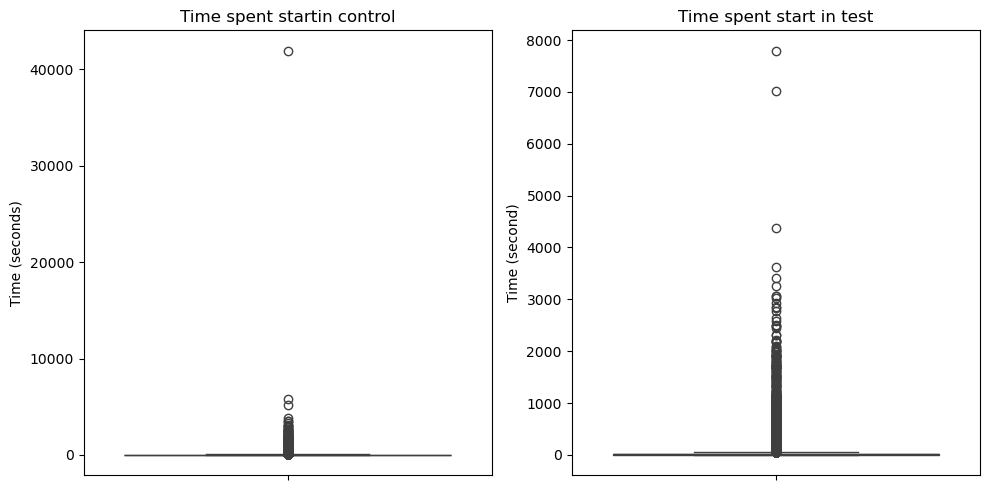

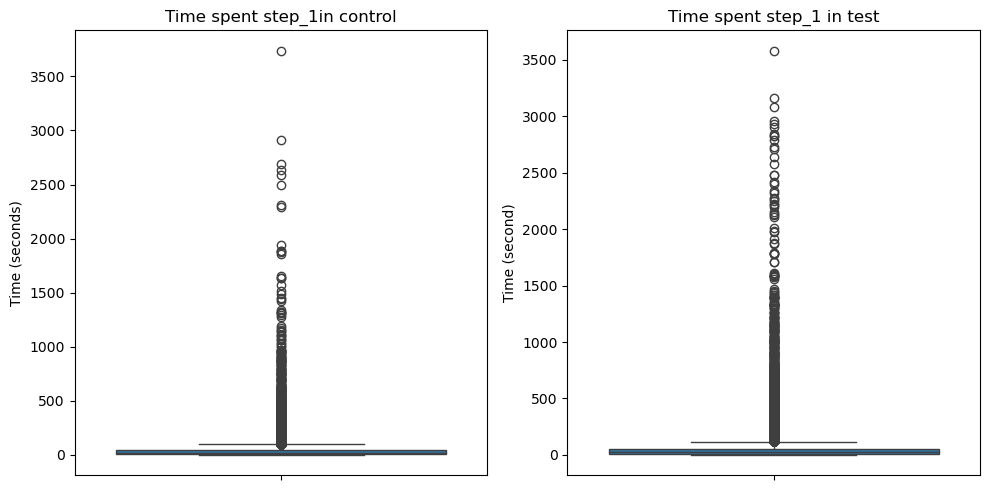

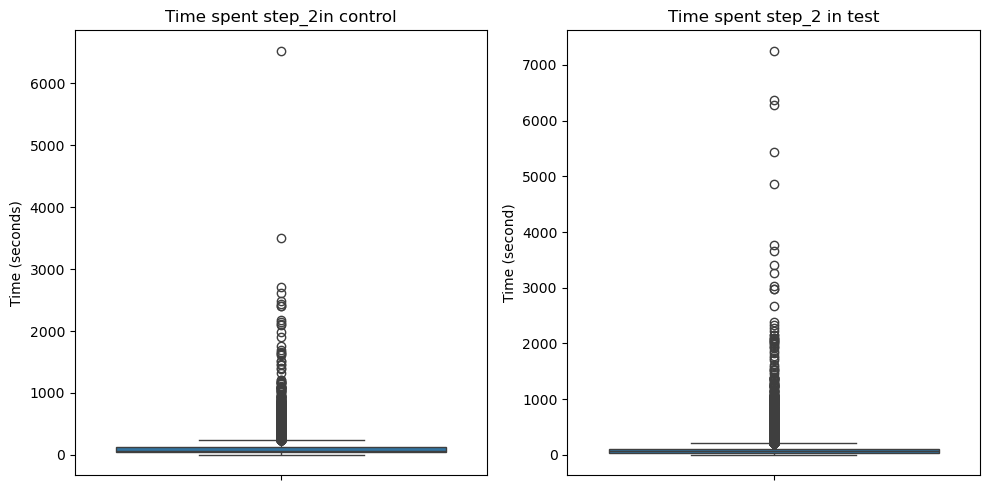

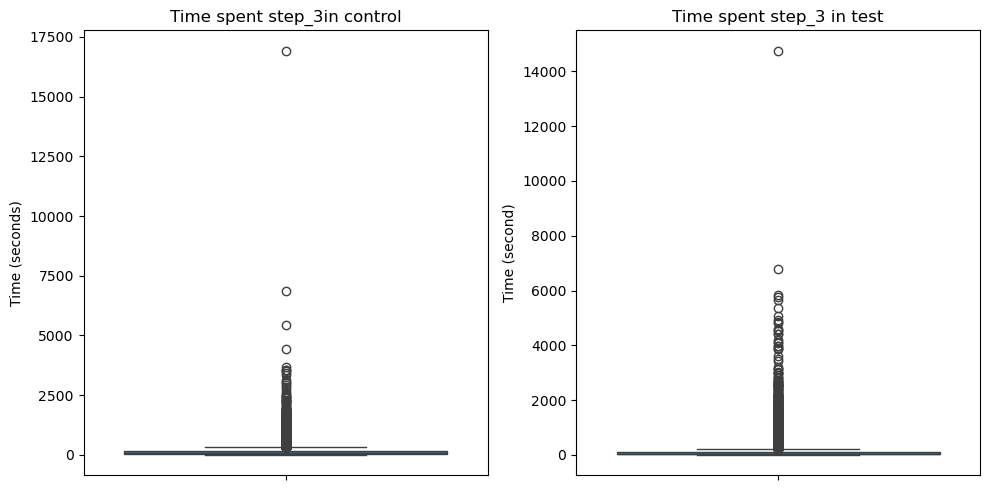

In [221]:
steps = df_valid_control_time['process_step'].unique().tolist()[:4]


for i in steps:

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.boxplot(y='time_in_second', data=df_valid_control_time[df_valid_control_time['process_step'] == i])
    plt.title(f'Time spent {i}in control')
    plt.ylabel('Time (seconds)')
    plt.subplot(1,2,2)
    sns.boxplot(y='time_in_second', data=df_valid_test_time[df_valid_test_time['process_step'] == i])
    plt.title(f'Time spent {i} in test')
    plt.ylabel('Time (second)')

    plt.tight_layout()
    plt.show()

In [222]:
df_valid_test_time['time_in_second'].describe()

count    128324.000000
mean         63.552843
std         180.024466
min           0.000000
25%           0.000000
50%          20.000000
75%          62.000000
max       14758.000000
Name: time_in_second, dtype: float64

In [223]:
df_valid_control_time['time_in_second'].describe()

count    107911.000000
mean         63.971986
std         205.261421
min           0.000000
25%           0.000000
50%          21.000000
75%          68.000000
max       41957.000000
Name: time_in_second, dtype: float64

Remove outliers

In [224]:
df_time_control_no_outliers = f.remove_outliers(df_valid_control_time, 'time_in_second')
df_time_test_no_outliers = f.remove_outliers(df_valid_test_time, 'time_in_second')

Lower Bound: -102.0
Upper Bound: 170.0
Lower Bound: -93.0
Upper Bound: 155.0


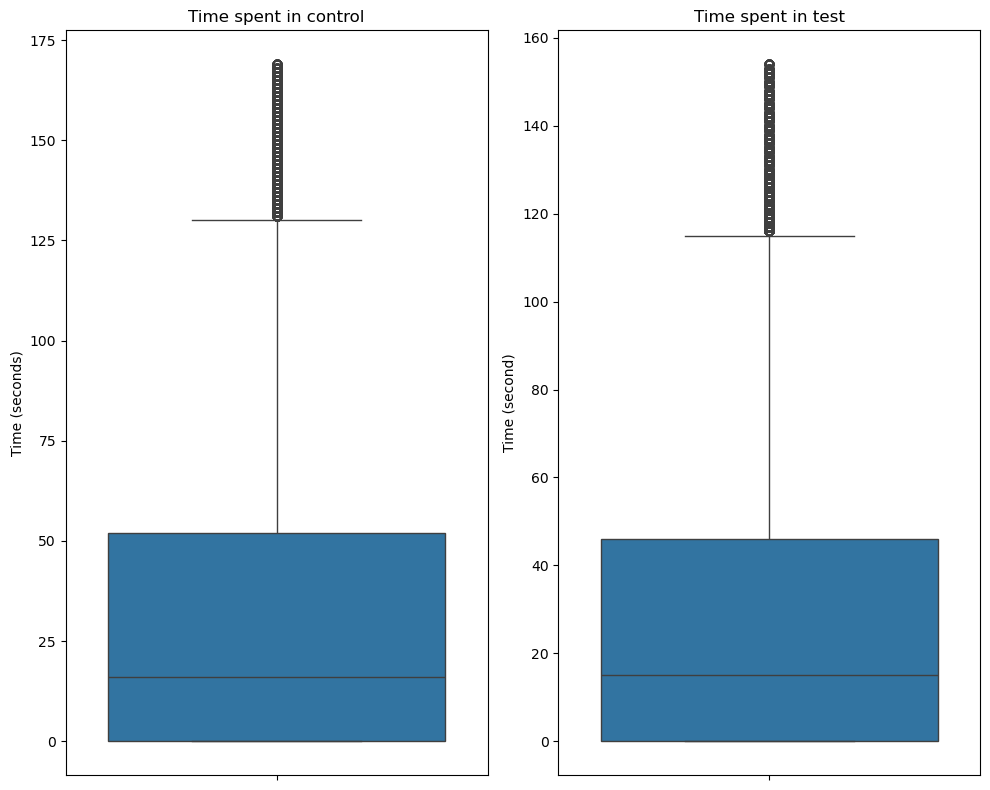

In [225]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.boxplot(y='time_in_second', data=df_time_control_no_outliers)
plt.title('Time spent in control')
plt.ylabel('Time (seconds)')
plt.subplot(1,2,2)
sns.boxplot(y='time_in_second', data=df_time_test_no_outliers)
plt.title('Time spent in test')
plt.ylabel('Time (second)')

plt.tight_layout()
plt.show()

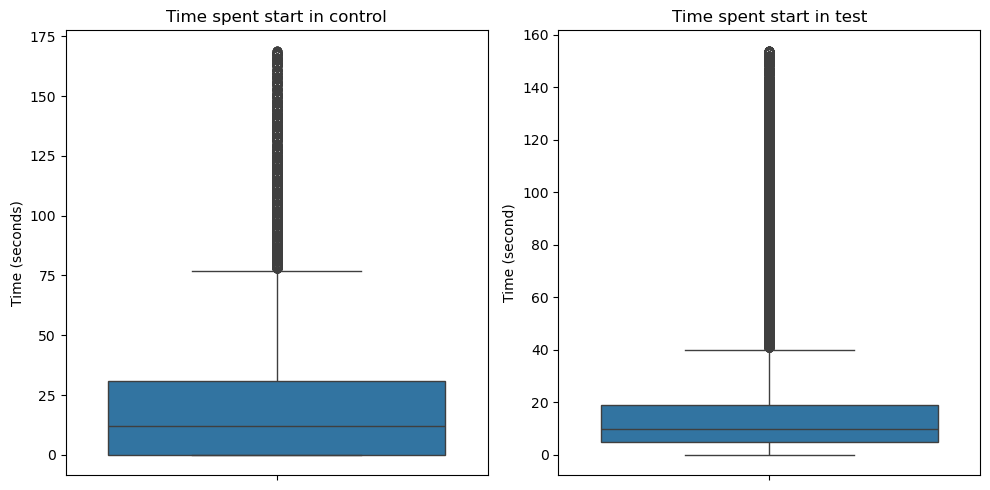

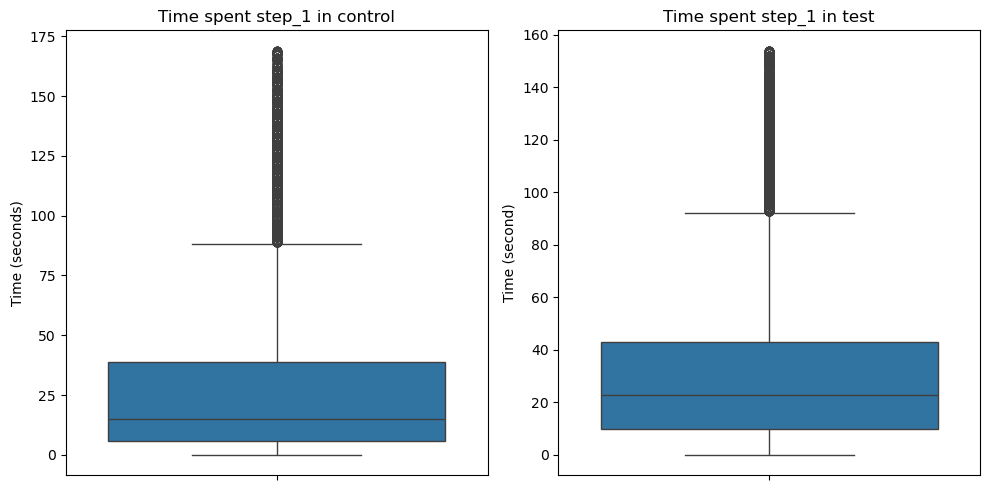

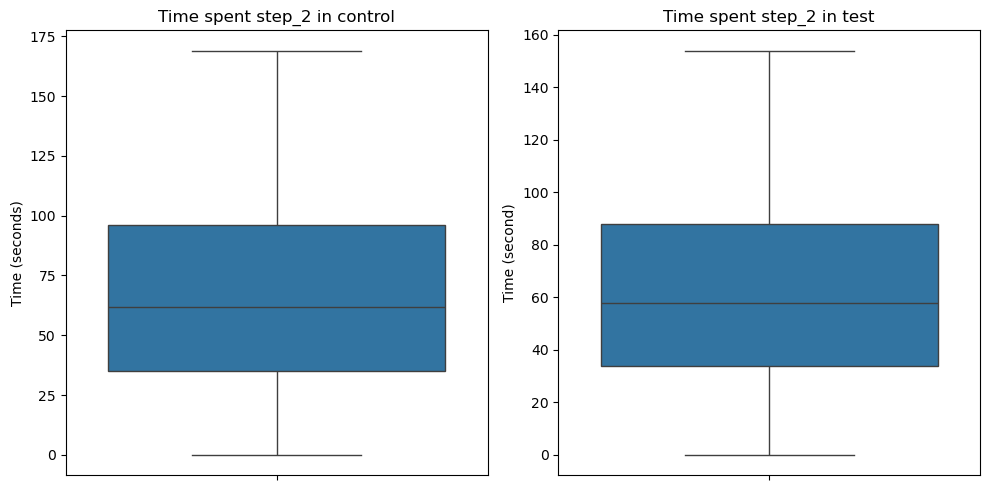

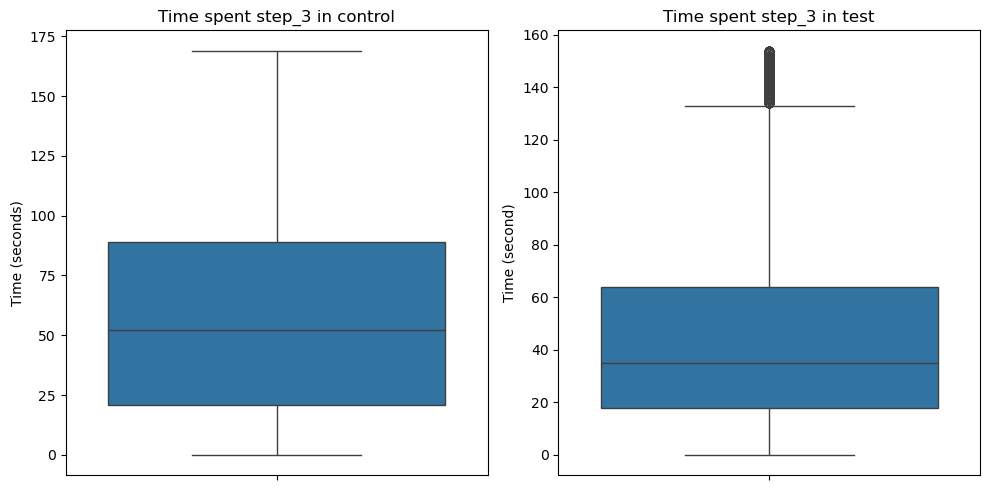

In [226]:
steps = ['start', 'step_1', 'step_2', 'step_3']

for i in steps:

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.boxplot(y='time_in_second', data=df_time_control_no_outliers[df_time_control_no_outliers['process_step'] == i])
    plt.title(f'Time spent {i} in control')
    plt.ylabel('Time (seconds)')
    plt.subplot(1,2,2)
    sns.boxplot(y='time_in_second', data=df_time_test_no_outliers[df_time_test_no_outliers['process_step'] == i])
    plt.title(f'Time spent {i} in test')
    plt.ylabel('Time (second)')

    plt.tight_layout()
    plt.show()

In [227]:
# create series with control and test step_time 
time_test = df_time_test_no_outliers['time_in_second']
time_control = df_time_control_no_outliers['time_in_second']

In [228]:
time_test.describe()

count    116795.000000
mean         29.732831
std          36.177815
min           0.000000
25%           0.000000
50%          15.000000
75%          46.000000
max         154.000000
Name: time_in_second, dtype: float64

In [229]:
time_control.describe()

count    98864.000000
mean        32.786029
std         40.107427
min          0.000000
25%          0.000000
50%         16.000000
75%         52.000000
max        169.000000
Name: time_in_second, dtype: float64

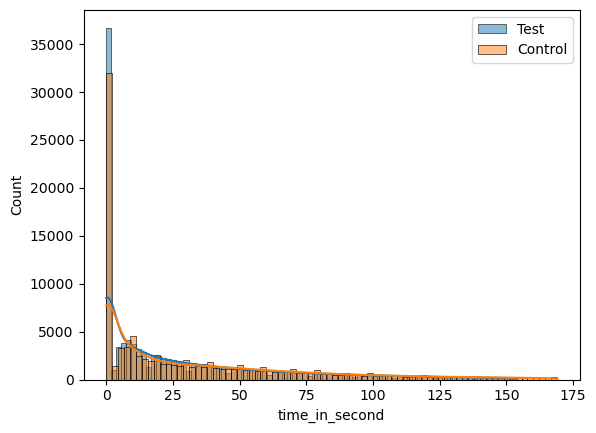

In [230]:
sns.histplot(time_test, kde=True, label='Test')
sns.histplot(time_control, kde=True, label='Control')
plt.legend()
plt.show()

In [231]:
time_test[time_test == 0]

252078    0.0
9539      0.0
82564     0.0
103804    0.0
103803    0.0
         ... 
20224     0.0
306135    0.0
306138    0.0
306132    0.0
50557     0.0
Name: time_in_second, Length: 36725, dtype: float64

<Axes: ylabel='Count'>

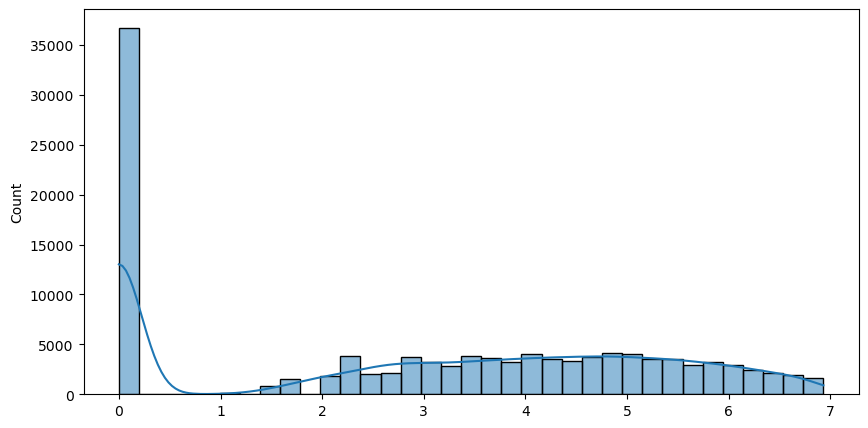

In [232]:
from scipy.stats import boxcox
import numpy as np

if np.any(time_test <= 0):
    offset = abs(min(time_test)) + 1
    time_test = time_test + offset

# Applying Box-Cox transformation to 'LotArea'
time_test, _ = boxcox(time_test)

# Plotting the transformed distributions
plt.figure(figsize=(10,5))

# Box-Cox transformed 'LotArea'
sns.histplot(time_test, kde=True)

<Axes: ylabel='Count'>

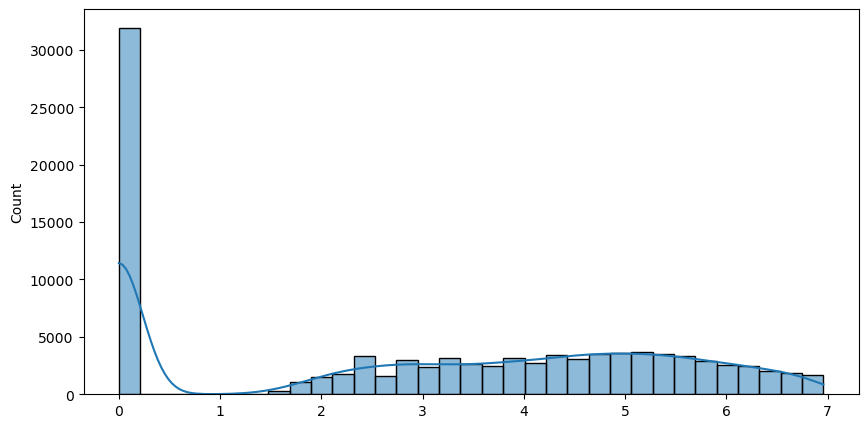

In [233]:
from scipy.stats import boxcox
import numpy as np

if np.any(time_control <= 0):
    offset = abs(min(time_test)) + 1
    time_control = time_control + offset

# Applying Box-Cox transformation to 'LotArea'
time_control, _ = boxcox(time_control)

# Plotting the transformed distributions
plt.figure(figsize=(10,5))

# Box-Cox transformed 'LotArea'
sns.histplot(time_control, kde=True)

### Returning to Step 3: Key Performance Indicators (KPIs)

4. **User Navigation per Visit ID:** Analyzing the user journey to identify where users typically stop their process.

In [234]:
df_valid_control_time[['client_id', 'visit_id', 'process_step', 'time_spent']]

,client_id,visit_id,process_step,time_spent
298528,1028,557292053_87239438319_391157,start,0 days 00:00:49
298527,1028,557292053_87239438319_391157,step_1,0 days 00:01:12
298525,1028,557292053_87239438319_391157,step_2,0 days 00:04:35
298524,1028,557292053_87239438319_391157,step_3,NaT
130633,1104,543158812_46395476577_767725,start,NaT
...,...,...,...,...
141088,9998346,189177304_69869411700_783154,step_1,0 days 00:00:45
141087,9998346,189177304_69869411700_783154,step_2,0 days 00:01:13
141084,9998346,189177304_69869411700_783154,step_3,0 days 00:09:28
141080,9998346,189177304_69869411700_783154,confirm,NaT


In [235]:
df_valid_control_time.isna().sum()

client_id                  0
clnt_tenure_yr             0
clnt_tenure_mnth           0
clnt_age                   0
gendr                      0
num_accts                  0
bal                        0
calls_6_mnth               0
logons_6_mnth              0
generation                 0
testing_engagement         0
balance_level              0
tenure                     0
Variation                  0
visitor_id                 0
visit_id                   0
process_step               0
date_time                  0
step_order                 0
repetition                 0
previous_step_order    31935
is_error                   0
time_spent             31935
time_in_second             0
dtype: int64

In [236]:
df_valid_control_time.isnull()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,generation,...,visitor_id,visit_id,process_step,date_time,step_order,repetition,previous_step_order,is_error,time_spent,time_in_second
298528,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
298527,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298525,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298524,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
130633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141088,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141087,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141084,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141080,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [237]:
df_control_steps_final = df_valid_control_time[df_valid_control_time['time_spent'].isnull()].groupby(by='process_step').agg('count').reset_index()[['process_step','visit_id']].rename(columns={'visit_id':'number_of_visits'}).sort_values(by='process_step')

In [238]:
df_control_steps_final

,process_step,number_of_visits
0,confirm,15911
1,start,7567
2,step_1,3477
3,step_2,2007
4,step_3,2973


In [239]:
df_test_steps_final = df_valid_test_time[df_valid_test_time['time_spent'].isnull()].groupby(by='process_step').agg('count').reset_index()[['process_step','visit_id']].rename(columns={'visit_id':'number_of_visits'}).sort_values(by='process_step')
df_test_steps_final

,process_step,number_of_visits
0,confirm,21566
1,start,5078
2,step_1,3874
3,step_2,2508
4,step_3,3698


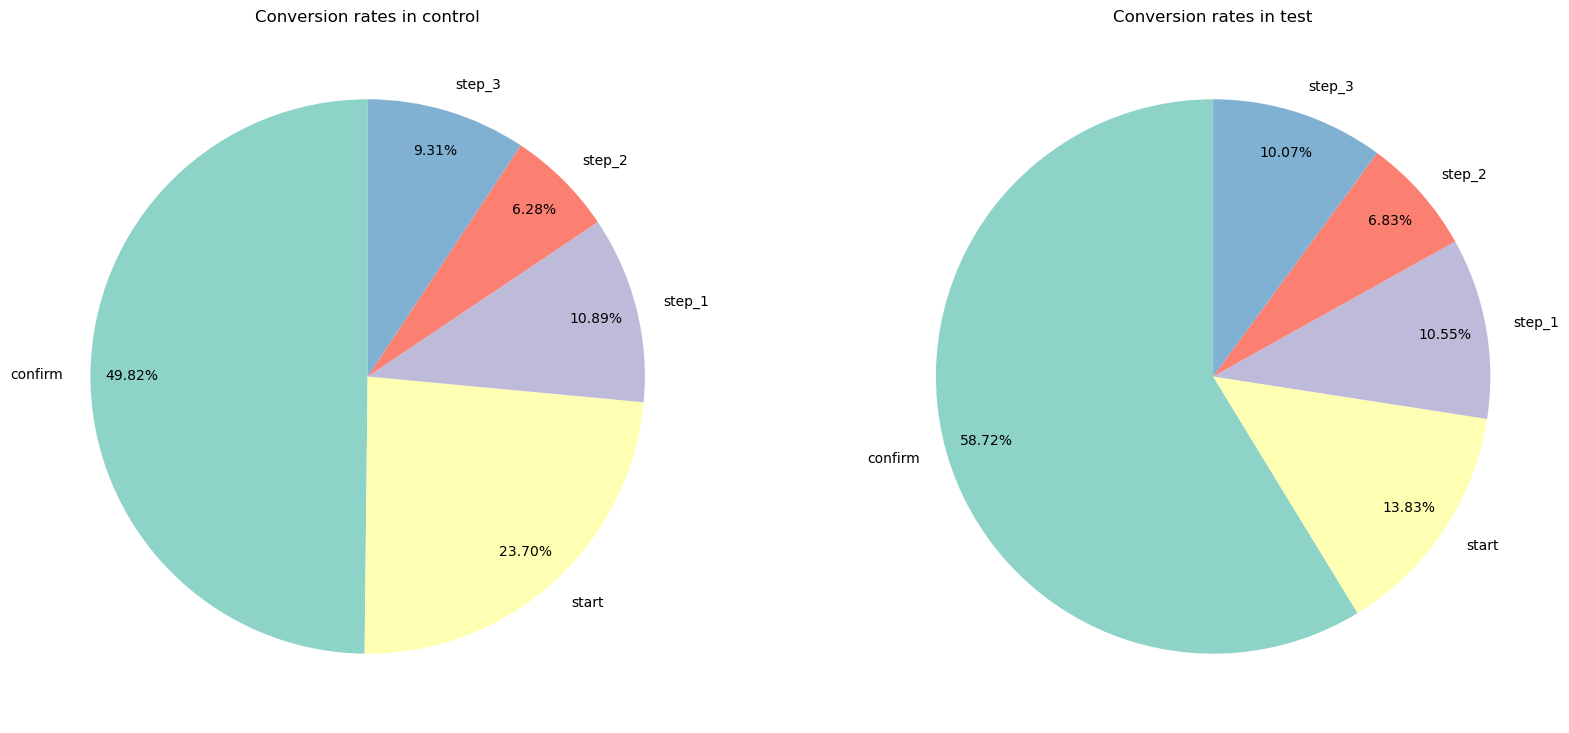

In [240]:
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.pie(df_control_steps_final['number_of_visits'], labels = df_control_steps_final['process_step'],autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85)
plt.title('Conversion rates in control')
#plt.show()
#plt.figure(figsize=(20,9))
plt.subplot(1,2,2)
plt.pie(df_test_steps_final['number_of_visits'], labels = df_test_steps_final['process_step'], autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"), pctdistance=0.85 )
plt.title('Conversion rates in test')
plt.show()

### Hypothesis: 
$$
H_0: \mu_{control} = \mu_{test},
$$

$$
H_1: \mu_{control} \neq \mu_{test}
$$



The test stadistic is:

$$
t = \frac{\overline{X} - \mu_0}{\frac{s}{\sqrt{n}}}
$$

Where: 
- $\overline{X}$ is sample mean.
- $\mu_0$ is hypothesized population mean.
- $s$ is std of the population.
- $n$ is the sample size.

In [241]:
mu_control = df_avg_second_control['time_in_second'].mean()
mu_test = df_avg_second_test['time_in_second'].mean()
me_control = df_avg_second_control['time_in_second'].median()
me_test = df_avg_second_test['time_in_second'].median()

In [242]:
f.t_student(df_avg_second_control, df_avg_second_test, 'time_in_second')

(0.06681086225550063,
 0.9490424043727508,
 'No rechazamos la hipótesis nula: no hay diferencia significativa.')